

## **Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ**

<font color='blue'>Шерман Марк, Stepik ID 114009835

<font color='blue'>Kaggle: https://www.kaggle.com/maurgsher

# Путешествие по Спрингфилду.


Сегодня вам предстоить помочь телекомпании FOX  в обработке их контента. Как вы знаете сериал Симсоны идет на телеэкранах более 25 лет и за это время скопилось очень много видео материала. Персоонажи менялись вместе с изменяющимися графическими технологиями   и Гомер 2018 не очень похож на Гомера 1989. Нашей задачей будет научиться классифицировать персонажей проживающих в Спрингфилде. Думаю, что нет смысла представлять каждого из них в отдельности.



 ![alt text](https://vignette.wikia.nocookie.net/simpsons/images/5/5a/Spider_fat_piglet.png/revision/latest/scale-to-width-down/640?cb=20111118140828)



### Установка зависимостей

In [1]:
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

In [3]:
api.competition_download_files('journey-springfield', path='dataset/')

In [5]:
from zipfile import ZipFile
zf = ZipFile('dataset/journey-springfield.zip')
zf.extractall('dataset/')
zf.close()

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [6]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms, models
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler
import torch.nn as nn

import random

from matplotlib import colors, pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [7]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [8]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 244x244 px
RESCALE_SIZE = 244
# работаем на видеокарте
DEVICE = torch.device("cuda")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation. 

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample) 

In [9]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        data_transforms = {
            'train': transforms.Compose([
                transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                transforms.RandomRotation(5),
                transforms.RandomHorizontalFlip(0.5),
                transforms.RandomCrop(size=(RESCALE_SIZE, RESCALE_SIZE), padding=10),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ]),
            'val': transforms.Compose([
                transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                transforms.CenterCrop(size=(RESCALE_SIZE, RESCALE_SIZE)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ]),
            'test': transforms.Compose([
                transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                transforms.CenterCrop(size=(RESCALE_SIZE, RESCALE_SIZE)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        }
        x = self.load_sample(self.files[index])
        x = data_transforms[self.mode](x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [10]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [11]:
TRAIN_DIR = Path('dataset/train/simpsons_dataset')
TEST_DIR = Path('dataset/testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [12]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25,
                                          stratify=train_val_labels,
                                          random_state=SEED)

In [13]:
train_dataset = SimpsonsDataset(train_files, mode='train')
val_dataset = SimpsonsDataset(val_files, mode='val')
test_dataset = SimpsonsDataset(test_files, mode='test')

Давайте посмотрим на наших героев внутри датасета.

([], <a list of 0 Text major ticklabel objects>)

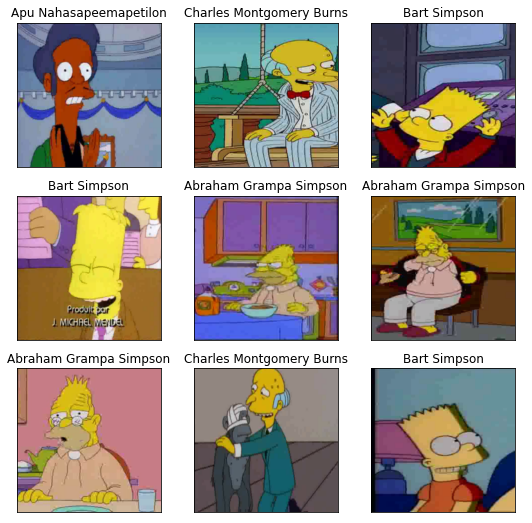

In [14]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(9, 9), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
plt.xticks([])
plt.yticks([]);

### Построение нейросети


In [15]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
    scheduler.step()          
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [16]:
def eval_epoch(model, val_loader, criterion, best_acc):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size

    if val_acc > best_acc:
        best_acc = val_acc
        best_model_wts = model.state_dict()

    return val_loss, val_acc, best_model_wts

In [17]:
def train(train_files, val_files, model, epochs, batch_size, opt=None):
    train_loader = DataLoader(train_dataset, batch_size=batch_size,
                              shuffle=True, worker_init_fn=SEED)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                            worker_init_fn=SEED)

    history = []
    best_acc = 0.0
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        if opt is None:
            opt = torch.optim.Adam(model.parameters(), lr=1e-3)
        criterion = nn.CrossEntropyLoss()
        exp_lr_scheduler = lr_scheduler.StepLR(opt, step_size=4, gamma=0.1)

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion,
                                              opt, exp_lr_scheduler)
            print("loss", train_loss)
            
            val_loss, val_acc, best_model_wts = eval_epoch(model, val_loader,
                                                           criterion, best_acc)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history, best_model_wts

In [18]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [19]:
model_ResNet = models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


In [20]:
modules = ['conv1', 'bn1', 'relu', 'maxpool']
for name, param in model_ResNet.named_parameters():
    if name in modules:
        param.requires_grad_ = False

In [21]:
num_features = 2048
n_classes = len(np.unique(train_val_labels))
model_ResNet.fc = nn.Linear(num_features, n_classes, bias=True)

model_ResNet.to(DEVICE);

In [22]:
optimizer = torch.optim.AdamW(params=[
        {"params": list(model_ResNet.fc.parameters()) +
            list(model_ResNet.avgpool.parameters())},
        {"params": list(model_ResNet.layer4.parameters()) +
            list(model_ResNet.layer3.parameters()), "lr": 1e-4},
        {"params": list(model_ResNet.layer2.parameters()) +
            list(model_ResNet.layer1.parameters()), "lr": 1e-5}
    ],
    lr=1e-3
)

In [23]:
history, model_wts = train(train_dataset, val_dataset, model=model_ResNet, epochs=10, batch_size=16, opt=optimizer)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


loss 0.5906754885272498


epoch:  10%|█         | 1/10 [06:39<59:52, 399.19s/it]


Epoch 001 train_loss: 0.5907     val_loss 0.1903 train_acc 0.8574 val_acc 0.9517
loss 0.20263978382472275


epoch:  20%|██        | 2/10 [13:21<53:21, 400.16s/it]


Epoch 002 train_loss: 0.2026     val_loss 0.1734 train_acc 0.9479 val_acc 0.9589
loss 0.17288168459161402


epoch:  30%|███       | 3/10 [20:05<46:49, 401.33s/it]


Epoch 003 train_loss: 0.1729     val_loss 0.1553 train_acc 0.9552 val_acc 0.9635
loss 0.12502759122034476


epoch:  40%|████      | 4/10 [26:48<40:11, 401.90s/it]


Epoch 004 train_loss: 0.1250     val_loss 0.1712 train_acc 0.9667 val_acc 0.9633
loss 0.05852106477979025


epoch:  50%|█████     | 5/10 [33:34<33:34, 402.98s/it]


Epoch 005 train_loss: 0.0585     val_loss 0.0949 train_acc 0.9869 val_acc 0.9813
loss 0.03474847071575443


epoch:  60%|██████    | 6/10 [40:18<26:52, 403.19s/it]


Epoch 006 train_loss: 0.0347     val_loss 0.0898 train_acc 0.9910 val_acc 0.9801
loss 0.02276797040275027


epoch:  70%|███████   | 7/10 [47:01<20:10, 403.34s/it]


Epoch 007 train_loss: 0.0228     val_loss 0.0889 train_acc 0.9947 val_acc 0.9818
loss 0.019992908373746347


epoch:  80%|████████  | 8/10 [53:44<13:26, 403.24s/it]


Epoch 008 train_loss: 0.0200     val_loss 0.0928 train_acc 0.9955 val_acc 0.9815
loss 0.012788695018262087


epoch:  90%|█████████ | 9/10 [1:00:27<06:43, 403.03s/it]


Epoch 009 train_loss: 0.0128     val_loss 0.0881 train_acc 0.9965 val_acc 0.9822
loss 0.013334732115597004


epoch: 100%|██████████| 10/10 [1:07:09<00:00, 402.99s/it]


Epoch 010 train_loss: 0.0133     val_loss 0.0862 train_acc 0.9968 val_acc 0.9841


In [24]:
loss, acc, val_loss, val_acc = zip(*history)

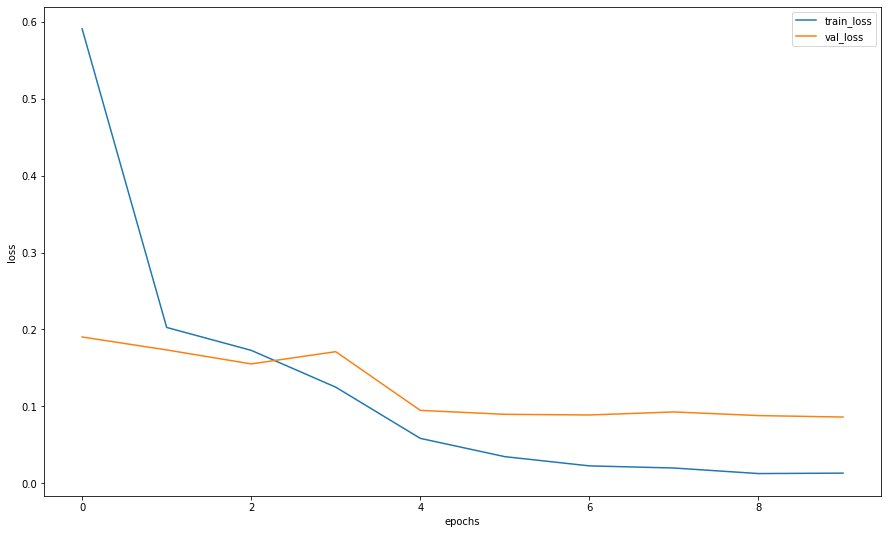

In [25]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [26]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [27]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model_ResNet, ex_img.unsqueeze(0))

In [28]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model_ResNet, imgs)

In [29]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [30]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [label_encoder.classes_[val_dataset[id][1]] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Метрика, которую необходимо оптимизировать в конкурсе - f1-score. Вычислим целевую метрику на валидационной выборке.

In [31]:
from sklearn.metrics import f1_score

f1_score(actual_labels, preds_class, average='micro')

1.0

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах.

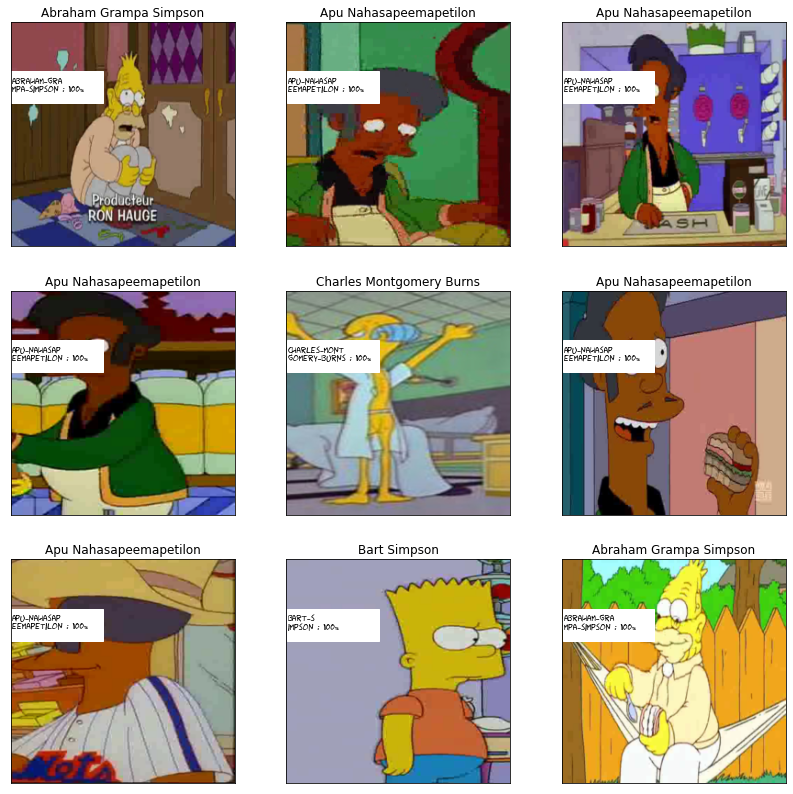

In [37]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(14, 14), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),100,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model_ResNet, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')
    
plt.xticks([])
plt.yticks([]);

### Submit на Kaggle

In [38]:
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model_ResNet, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [40]:
#СОХРАНЯЕМ ВЕСА МОДЕЛИ
torch.save(model_ResNet.state_dict(), 'New_ResNet_Weights')

In [41]:
import pandas as pd

submission = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
submission.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [42]:
submission.to_csv('drive/My Drive/DeepLearningSchool/kaggle_2/baseline.csv', index=False)